# Scientific Chart Extraction Pipeline Validation

This notebook validates the full 3-stage pipeline for extracting data from scientific charts:

1.  **Stage 1 (Macro Detection)**: 
    -   **TF-ID (Florence-2)**: Detect Tables & Figures from PDF pages.
    -   **YOLOv11n (Macro)**: Identify 'target_image' (plot) & 'legend_area'. Crop & Mask non-data elements (text, axes).
2.  **Stage 2 (Micro Detection)**:
    -   **YOLOv11m (Micro)**: Detect `data_point`, `tick_mark` on the cleaned plot.
3.  **Data Mapping**:
    -   **LegendMatcher**: Match data points to series using legend crops (Color/Shape).
    -   **CoordinateMapper**: OCR tick labels, perform Linear Regression, and map pixels to physical values.

In [1]:
import os
import sys
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image

# Add src to path
sys.path.append(os.path.abspath('../'))

from src.parsing.active_area_detector import ActiveAreaDetector
from src.parsing.yolo_detector import YoloDetector
from src.parsing.stage2_detector import Stage2Detector
from src.extraction.legend_matcher import LegendMatcher
from src.extraction.coordinate_mapper import CoordinateMapper
from config import Config

def show_img(path_or_array, title="Image"):
    if isinstance(path_or_array, str):
        if not os.path.exists(path_or_array):
            print(f"Image not found: {path_or_array}")
            return
        img = cv2.imread(path_or_array)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    else:
        img = path_or_array
        
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()

/Users/zhaowenyuan/Projects/FlowFigTabMiner/flowfigtabminer/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/zhaowenyuan/Projects/FlowFigTabMiner/flowfigtabminer/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Checking connectivity to the model hosters, this may take a while. To bypass this check, set `DISABLE_MODEL_SOURCE_CHECK` to `True`.


## 1. Initialize Models

In [2]:
# Initialize all detectors
print("Initializing Models... This may take a moment.")

try:
    # Stage 1
    tf_id_detector = ActiveAreaDetector()
    
    # Macro YOLO (Cleaning)
    yolo_macro = YoloDetector(model_path="../models/bestYOLOn-2-1.pt")
    
    # Micro YOLO (Points/Ticks)
    yolo_micro = Stage2Detector(model_path="../models/bestYOLOm-2-2.pt")
    
    # Logic Modules
    legend_matcher = LegendMatcher()
    coord_mapper = CoordinateMapper()
    
    print("✅ All models initialized successfully.")
    
except Exception as e:
    print(f"❌ Initialization Failed: {e}")

Initializing Models... This may take a moment.
Loading TF-ID (Florence-2) model: yifeihu/TF-ID-base on mps...


Florence2LanguageForConditionalGeneration has generative capabilities, as `prepare_inputs_for_generation` is explicitly defined. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


PATCHING: Adding GenerationMixin to Florence2LanguageForConditionalGeneration bases for compatibility.
PATCHING: Initializing missing generation_config for language_model.
Loading YOLO model from ../models/bestYOLOn-2-1.pt...
Loading Stage 2 YOLO model from ../models/bestYOLOm-2-2.pt...


/Users/zhaowenyuan/Projects/FlowFigTabMiner/flowfigtabminer/lib/python3.9/site-packages/paddle/utils/cpp_extension/extension_utils.py:712: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and install ccache from: https://github.com/ccache/ccache/blob/master/doc/INSTALL.md
  warnings.warn(warning_message)
Creating model: ('PP-LCNet_x1_0_doc_ori', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/Users/zhaowenyuan/.paddlex/official_models/PP-LCNet_x1_0_doc_ori`.
Creating model: ('UVDoc', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/Users/zhaowenyuan/.paddlex/official_models/UVDoc`.
Creating model: ('PP-LCNet_x1_0_textline_ori', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/Users/zhaowenyuan/.paddlex/official_models/PP-LCNet_x1_0_textline_ori`.


✅ All models initialized successfully.


## 2. Load PDF & Run Stage 1 (TF-ID)

Processing: ../data/input/example.pdf
Found 7 figures.
Sample Figure: ../data/intermediate_validation/example/figures/page_2_figure_0.png


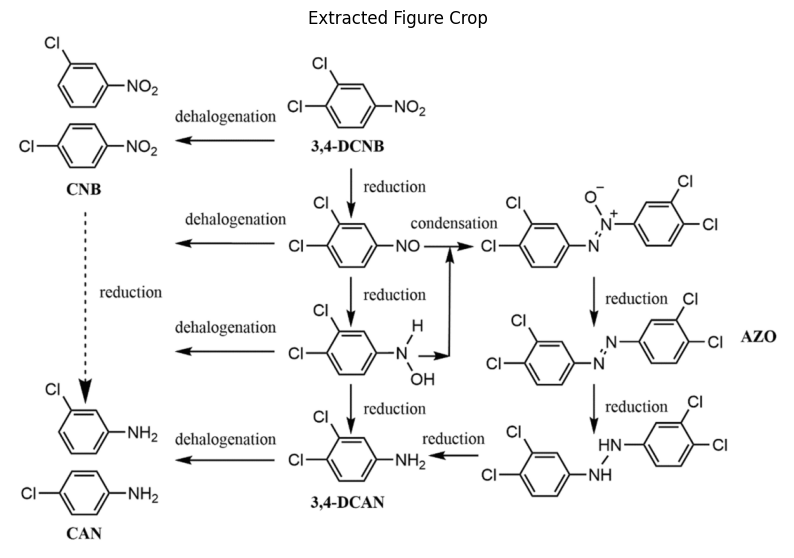

In [3]:
# Select a PDF
pdf_name = "example.pdf" # Change this to test other PDFs
pdf_path = os.path.join("../data/input", pdf_name)

if not os.path.exists(pdf_path):
    print(f"PDF not found: {pdf_path}")
else:
    print(f"Processing: {pdf_path}")
    
    # Run TF-ID
    detections = tf_id_detector.process_pdf(pdf_path)
    
    # Save Crops
    intermediate_dir = "../data/intermediate_validation"
    saved_paths = tf_id_detector.save_crops(pdf_path, detections, intermediate_dir)
    
    figures = [p for p in saved_paths if '_figure_' in p]
    print(f"Found {len(figures)} figures.")
    
    # Show first figure crop if exists
    if figures:
        print(f"Sample Figure: {figures[0]}")
        show_img(figures[0], "Extracted Figure Crop")

## 3. Run Stage 2A: Macro YOLO (Clean & Mask)
Separates the 'Plot Area' and masks text/axes to prepare for micro-detection.

   YOLO Processing: page_2_figure_0...
      -> No target_image detected. Skipping.
   YOLO Processing: page_3_figure_0...
      -> No target_image detected. Skipping.
   YOLO Processing: page_5_figure_0...
      -> Saved page_5_figure_0_t0_cleaned.png (masked 4 elements)
Processed 1 plots.
Source: page_5_figure_0.png


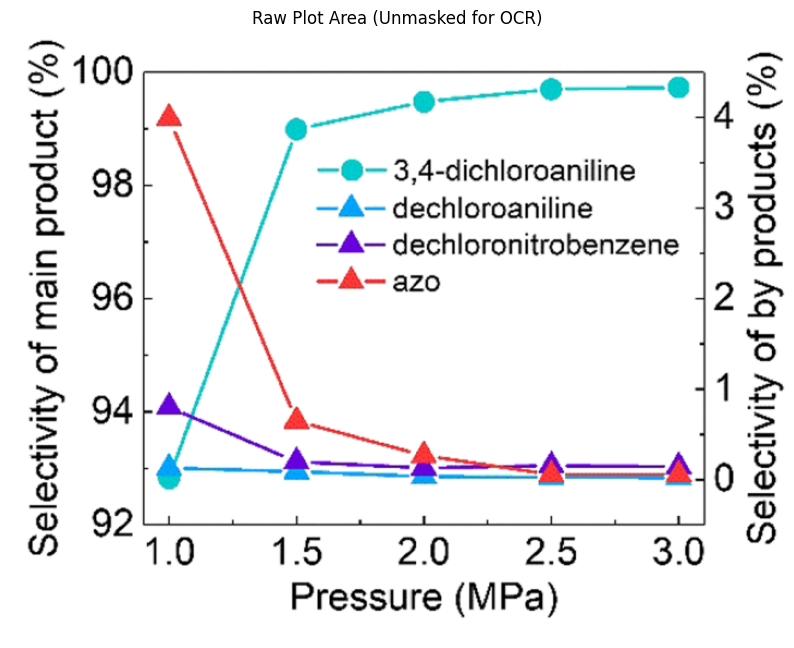

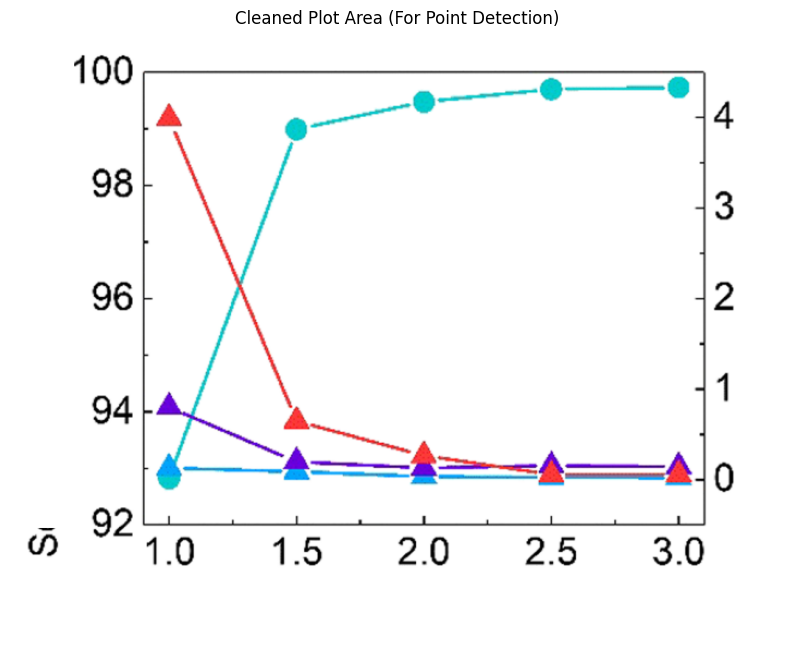

In [4]:
# Run Macro YOLO on detected figures
macro_results = []
if figures:
    # Just process the first few to save time
    test_figures = figures[:3] 
    macro_results = yolo_macro.process_images(test_figures, output_base_dir=intermediate_dir, output_subdir_name="macro_cleaned")
    
    print(f"Processed {len(macro_results)} plots.")
    
    # Visualization of the first result
    if macro_results:
        first_res = macro_results[0]
        print(f"Source: {os.path.basename(first_res['original_source'])}")
        
        # Show Raw Plot (Unmasked)
        # YoloDetector now saves raw crop as well
        raw_path = first_res.get('raw_image')
        clean_path = first_res.get('cleaned_image')
        
        if raw_path and os.path.exists(raw_path):
            show_img(raw_path, "Raw Plot Area (Unmasked for OCR)")
        
        if clean_path and os.path.exists(clean_path):
            show_img(clean_path, "Cleaned Plot Area (For Point Detection)")

## 4. Run Stage 2B: Micro YOLO (Points & Ticks)
Detects faint data markers and tick marks on the *cleaned* image.

Running Micro Detection on: ../data/intermediate_validation/macro_cleaned/page_5_figure_0_t0_cleaned.png
Detected 12 Data Points and 37 Ticks.


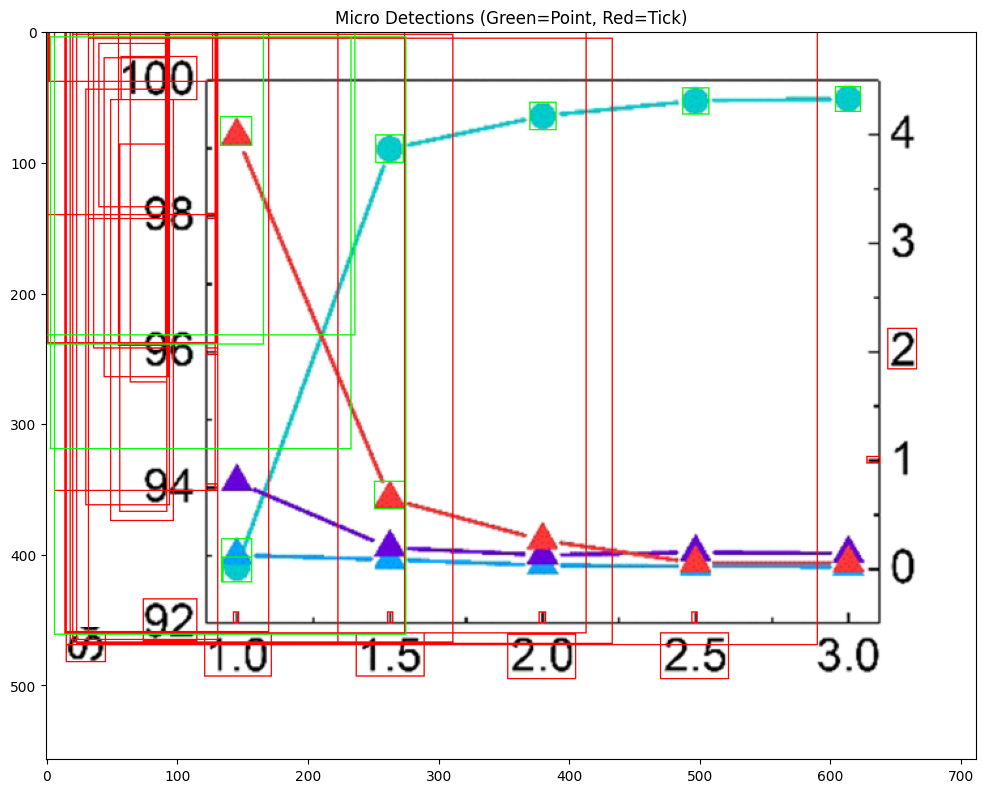

In [ ]:
selected_result = macro_results[0] if macro_results else None

if selected_result:
    clean_path = selected_result['cleaned_image']
    
    # Lower confidence for better point detection
    print(f"Running Micro Detection on: {clean_path}")
    micro_detections = yolo_micro.detect(clean_path, conf=0.5)
    
    data_points = [d for d in micro_detections if d['label'] == 'data_point']
    tick_marks = [d for d in micro_detections if 'tick' in d['label']]
    
    print(f"Detected {len(data_points)} Data Points and {len(tick_marks)} Ticks.")
    
    # Visualize Detections
    img_viz = cv2.imread(clean_path)
    img_viz = cv2.cvtColor(img_viz, cv2.COLOR_BGR2RGB)
    
    for d in micro_detections:
        box = d['box']
        color = (0, 255, 0) if d['label'] == 'data_point' else (255, 0, 0)
        # Thickness 1 for fine details
        cv2.rectangle(img_viz, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), color, 1)
        
    plt.figure(figsize=(12, 12))
    plt.imshow(img_viz)
    plt.title(f"Micro Detections (Green=Point, Red=Tick)")
    plt.show()

## 5. Legend Matching & Coordinate Mapping
Combine detections with Legend information and Tick Labels.

In [ ]:
if selected_result and data_points:
    # 1. Legend Matching
    legend_crops = selected_result['elements'].get('legend', [])
    prototypes = {}
    
    print("\n--- Legend Analysis ---")
    for lc in legend_crops:
        print(f"Parsing Legend Crop: {lc}")
        protos = legend_matcher.parse_legend(lc)
        prototypes.update(protos)
        # visualize legend crop
        show_img(lc, "Legend Crop")
    
    print(f"Extracted Series Prototypes: {list(prototypes.keys())}")
    
    # Match points
    # Note: LegendMatcher needs color from the *cleaned* or *raw* plot?
    # Points were detected on 'cleaned_image'. We should use that for color extraction.
    # Or better, the RAW image if points are overlaid on raw.
    # But 'cleaned' preserves points, only removes text.
    matched_points = legend_matcher.match_points(micro_detections, prototypes, selected_result['cleaned_image'])
    
    # 2. Coordinate Mapping
    # Use RAW image for OCR of ticks (as they are masked in cleaned image!)
    raw_path = selected_result.get('raw_image', selected_result['cleaned_image'])
    
    print(f"\n--- Mapping Coordinates (using {os.path.basename(raw_path)}) ---")
    df = coord_mapper.map_coordinates(matched_points, raw_path)
    
    print("\n--- Final Extracted Data ---")
    if not df.empty:
        display(df.head(20))
    else:
        print("No data extracted (Regression failed or no labels found).")